# Clasificación de texto - Predecir el tono de un tweet

### Autor: Roberto Maeso Benito
Junio 2021

**Resumen del notebook**

Se ha escogido este dataset (https://www.kaggle.com/kazanova/sentiment140) para realizar la clasificación de texto. Es una base de datos que contiene 1.600.000 tweets extraídos usando la API de Twitter. Los tweets han sido clasificados como 0 (sentimiento negativo) y 4 (sentimiento positivo). Nuestro objetivo es realizar un modelo de clasificación de texto con el que podamos detectar y clasificar el tono del tweet con la mayor precisión posible. De los 6 campos que contiene la base de datos únicamente vamos a utilizar las variable que clasifica el tweet (target) y el propio texto (text).

A nivel de limpieza y pre-procesado de datos, se ha partido del realizado en clase, utilizando el pre trained embbeding de Glove (glove.6B.50d.txt), y se ha añadido un análisis adicional en la parte de limpieza de las palabras, identificando también aspectos como el usuario, los links de las web de los tweets o los emojis. 

Asimismo, se ha incluido un análisis exploratorio de los datos, identificando las palabras positivas y negativas que más aparecen en el conjunto de tweets. Para ello, se ha utiliza la libreria de Wordcloud, que es ampliamente utilizada para analizar de forma visual las bases de datos que contienen texto.

En relación con la modelización, se han realizado dos análisis diferenciados. Por un lado, se ha realizado una red neuronal recurrente básica. Por otro lado, y dado que los resultados que se obtienen en terminos de precisión son relativamente bajos, se ha realizado un modelo LSTM Bidireccional, similar al visto en la clase de clasificación de texto. De forma adicional, se ha añadido un hyperparameter tuning sobre este modelo LSTM Bidireccional, escogiendo los parametros más idoneos de cara a obtener la máxima precisión posible. 

### Tabla de contenidos  <a name="indice"></a>

- [Importing libraries and creating functions & parameters](#data)
- [Loading data and embedding](#lde)
- [Pre-Process dataset & Feature engineering](#fe)
- [Exploratory data analysis](#eda)
- [Vectorization](#vec)
- [Word Embeddings](#tf)
- [Modeling](#m)
    - [Basic RNN Model](#basenn)
    - [Bidirectional LSTM Model](#1nn)
- [Hyperparameter tuning](#hp)
- [Conclusion](#conclusion)

### Importing libraries and creating functions & parameters<a name="data"></a> 
[Volver al índice](#indice)

Cargamos principalmente tres tipologías de librerias: (i) para manipulación de datos y pre-processing (pandas, numpy, seaborn, etc.); (ii) para el desarrollo de la modelización (tensorflow, sklearn, etc.) y (iii) para el clasificador de texto (nltk.corpus, nltk.tokenize)

In [1]:
import tensorflow as tf
print(tf.__version__)

import csv
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, LSTM, Embedding, Dropout, Bidirectional,\
SpatialDropout1D, Conv1D, MaxPooling1D, Flatten
#from keras.layers.embeddings import Embedding
from tensorflow.keras import layers, initializers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers

import re
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
stop_words = set(stopwords.words('english'))

%matplotlib inline

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
2.5.0-rc0


### Loading data and embedding<a name="lde"></a> 
[Volver al índice](#indice)

Al igual que en clase, se utiliza el embedding layer de Tensorflow Hub:
https://tfhub.dev/s?subtype=module,placeholder

In [2]:
pre_trained_embedding = "glove.6B.50d.txt"

Leemos la base de datos únicamente extrayendo los dos variables que nos interesan (label y text)

In [3]:
filename = "twitter_sentiment.csv"
df = pd.read_csv(filename
                 , encoding = 'latin'
                 , index_col = False
                 , header = 1
                 , usecols = [0, 5]
                 , names = ['label', 'text']
)
print(df.shape)
df.head()

(1599998, 2)


,label,text
0,0,@Kenichan I dived many times for the ball. Man...
1,0,my whole body feels itchy and like its on fire
2,0,"@nationwideclass no, it's not behaving at all...."
3,0,@Kwesidei not the whole crew
4,0,Need a hug


Cambiamos el label para convertir a texto de cara a entender mejor cuando ese tweet es clasificado como negativo, positivo y neutro

In [4]:
tonos = {0: "negativo", 2: "neutro", 4: "positivo"}
def get_tone(label):
    return tonos[int(label)]

In [5]:
df['label'] = df['label'].apply(lambda x: get_tone(x))
df.head()

,label,text
0,negativo,@Kenichan I dived many times for the ball. Man...
1,negativo,my whole body feels itchy and like its on fire
2,negativo,"@nationwideclass no, it's not behaving at all...."
3,negativo,@Kwesidei not the whole crew
4,negativo,Need a hug


A continuación graficamos el número de tweets positivos, neutros y negativos que tenemos en la base de datos

df shape :(1599998, 2)
positivo    800000
negativo    799998
Name: label, dtype: int64


<AxesSubplot:xlabel='unique_values'>

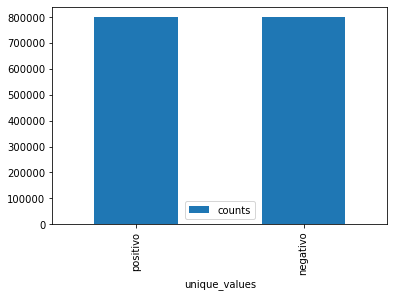

In [6]:
def get_list_counts(df, feature, pandas = False):
    df = df.copy(deep=True)
    x = df[feature].value_counts()
    if pandas:
        x = x.rename_axis('unique_values').reset_index(name='counts')
    return x

print('df shape :' + str(df.shape)) # imprimimos shape dataset
print(df['label'].value_counts())   # imprimimos el número de cada label
# plpot label distirbution
label_count = get_list_counts(df, 'label', pandas = True)
label_count.set_index('unique_values').plot(kind='bar')

Como vemos se trata de una base de datos balanceada ya que tenemos practicamente los mismos tweets positivos y negativos

### Pre-Process dataset & Feature engineering<a name="fe"></a> 
[Volver al índice](#indice)

Antes de comenzar con la limpieza del texto utilizamos langdetect para encontrar los idiomas más representados de la base de datos. Dado que contamos con mucha información y para reducir el computo de los datos, tomamos una muestra aleatoria simple de los datos (como los datos están balanceados no necesitamos tener en cuenta otros métodos de muestreo)

In [7]:
df_sample=df.sample(frac=0.001, replace=True, random_state=1)

<AxesSubplot:xlabel='unique_values'>

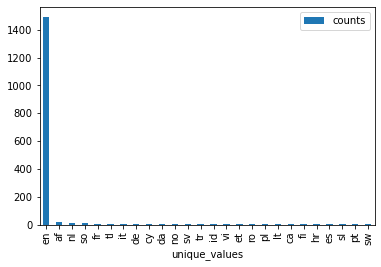

In [8]:
#Count lang distributiopn in sample data (this is very inefficient, try to run only if necesary)
from langdetect import detect

df_sample['lang'] = [detect(t) for t in df_sample['text']]

#df_labels = pd.DataFrame(train_labels, columns =['labels'])
label_count = get_list_counts(df_sample, 'lang', pandas = True)
label_count.set_index('unique_values').plot(kind='bar')

Dado que la mayoría de tweets son en ingles el análisis y la limpieza de texto se va a llevar considerando únicamente este idioma.

**Cleaning text**

Partiendo del ejercicio construido en clase, se ha añadido algunos análisis adicionales para el procesado de los datos, ya que este parte tiene un alto impacto en los resultados del modelo. A continuación se muestran los pasos realizados:
- Convertir a minusculas todas las palabras
- Reemplazar los emojis (se ha utilizado un diccionario encontrado en Kaggle con los principales emojis) por su sifnificado
- Eliminar todos los números de los tweets, ya que no tiene ninguna implicación en si el tono de este es considerado positivo o negativo
- Reemplazar los links por URL
- Reemplazar los nombres de los usuarios de twitter por USER
- Eliminar las palabras que contienen 3 letras similares y reemplazarlas por 2 letras consecutivas
- Se usa la lemmatizing, que basicamente es el proceso de cambiar una palabra a su forma gramatical básica
- Eliminar las palabras cortas y las denominadas como stopwords (palabras muy usadas que no añaden significado sobre el tono). Las stopwords al final no se han elimnado ya que bajaba de forma significativa la precisión de los modelos. No obstante, en la propia función de limpieza del texto se puede eliminar el comentario para eliminar estas palabras.

In [9]:
# Diccionario encontrado en Kaggle con los principales EMOJIS y su significado asociado
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [10]:
def get_clean_text(text):
    get_clean_text = []
    
    # Definimos en regex los patrones de los tweets que vamos a querer cambiar
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    # Usamos de la nltk el Lemmatizer
    wordLemm = WordNetLemmatizer()
    
    for tweet in text:
        tweet = tweet.lower()
        # Para cada uno de los patrones definimos vamos llevar a cabo la limpieza de cada tweet
        # URL
        tweet = re.sub(urlPattern,' URL',tweet)
        # Reemplazamos 3 letras consecutivas por 2
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        # Emojis
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Eliminamos números
        tweet = re.sub(alphaPattern, " ", tweet)
        # Usuario
        tweet = re.sub(userPattern,' USER', tweet)        

        tweetwords = ''
        for word in tweet.split(): 
            #if word not in stop_words: # finalmente no se eliminan las stopwords ya que restan precisión al modelo
                if len(word)>1:
                    word = wordLemm.lemmatize(word)
                    tweetwords += (word+' ')
            
        get_clean_text.append(tweetwords)
        
    return get_clean_text

In [11]:
text, label = list(df['text']), list(df['label'])
text_clean = get_clean_text(text)

In [12]:
col = {'text':text_clean,'label':label}
df = pd.DataFrame(col, columns=['text','label'])
df.head(30)

,text,label
0,kenichan dived many time for the ball managed ...,negativo
1,my whole body feel itchy and like it on fire,negativo
2,nationwideclass no it not behaving at all mad ...,negativo
3,kwesidei not the whole crew,negativo
4,need hug,negativo
5,loltrish hey long time no see yes rain bit onl...,negativo
6,tatiana nope they didn have it,negativo
7,twittera que me muera,negativo
8,spring break in plain city it snowing,negativo
9,just re pierced my ear,negativo


Como se puede comprobar se han eliminado aquellos datos y simbolos que no pueden ser atribuidos facilmente a un tono positivo o negativo. Por este motivo, nos quedamos con la nueva variable de text que hemos limpiado

### Exploratory Data Analysis<a name="eda"></a> 
[Volver al índice](#indice)

Antes de comenzar a modelizar vamos a visualizar las principales palabras que nos salen en uno y otro tono

Primero analizamos las palabras **negativas** más frecuentemente utilizadas y posteriormente las **positivas**

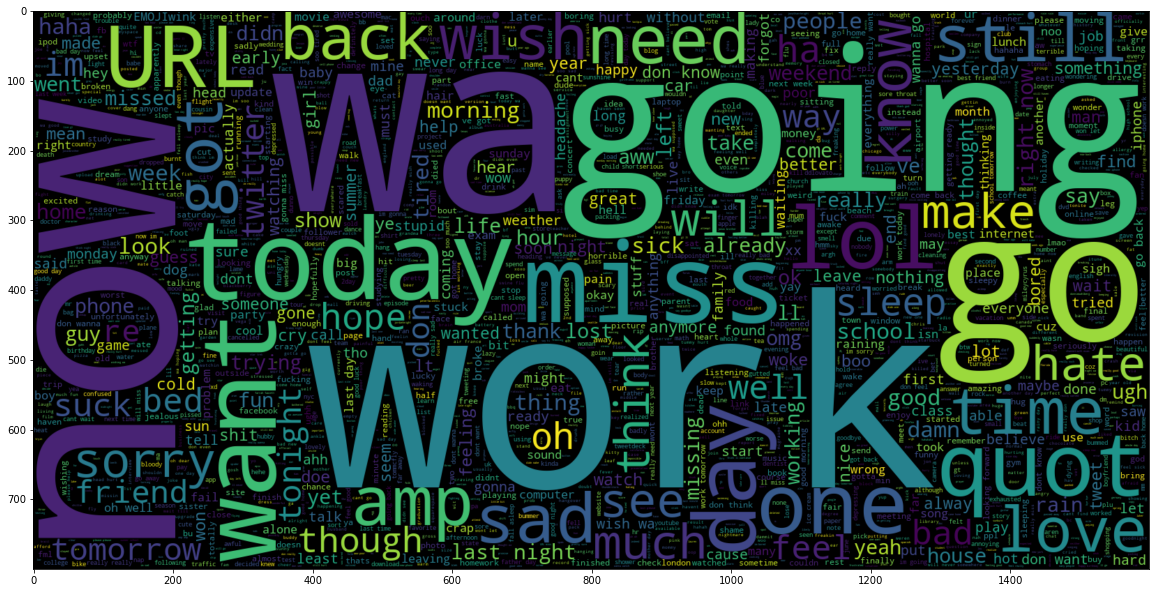

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
plt.figure(figsize = (20,20)) 
w = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.label == 'negativo'].text))
plt.imshow(w , interpolation = 'bilinear')

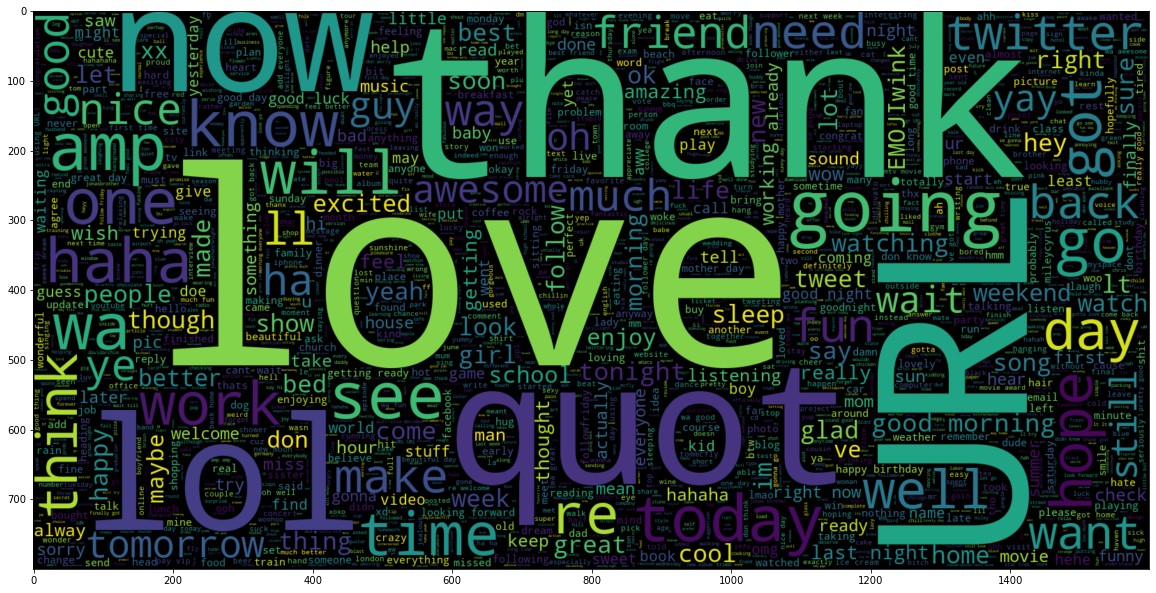

In [14]:
plt.figure(figsize = (20,20)) 
w_positivo= WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.label == 'positivo'].text))
plt.imshow(w_positivo, interpolation = 'bilinear')

Si visualizamos las palabras positivas y negativas más frecuentes vemos que hay algunas curiosas. Por ejemplo, adjuntar el link puede estar asociado tanta con un tono positivo como negativo. Se probó a eliminar estas palabras (lol, quot, link, user, etc.) que parecen verse de forma muy frecuente tanto en tweets con tono positivo como negativo, pero no afectaban a los resultados finales obtenidos con los distintos modelos

### Vectorization<a name="vec"></a> 
[Volver al índice](#indice)


In [15]:
label_distinct = len(set(df['label'])) # this might be use as a dynamic parameter for the cost function layer (number of output neurons)

x_train, x_val, y_train, y_val = train_test_split(text_clean, label,
                                                    test_size = 0.2, random_state = 0)

print('x_train records :' + str(len(x_train)))
print('y_train records :' + str(len(y_train)))
print('x_val records :' + str(len(x_val)))
print('y_val records :' + str(len(y_val)))

x_train records :1279998
y_train records :1279998
x_val records :320000
y_val records :320000


En lugar de definir como parametro el tamaño del vocab, se calcula el tamaño a partir de nuestros datos. Posteriormente, añadimos ceros (este proceso se denomina **padding**) en la secuencia para poder tener los mismos vectores en toda las secuencias de números

In [16]:
# parameters tokenize
vocab_size = 15000 # max tokens to be considered in vocabulary based on frequency
oov_tok = '<OOV>' # code for unseen tokens

label_tokenizer = Tokenizer() # Tokenizer is a functionality from tensorflow wich transforms words into numbers. Once a word
# has been converted to a number, every consecutive upcoming word already seen is converted to the same number
# This process is called tokenization
label_tokenizer.fit_on_texts(y_train) # fit will return a dictionary
label_index = label_tokenizer.word_index # save indexes for reverse transformation

# Tokenizer indexes from 1 to p, where p is number of categories.
# Is useful to substract 1 in order to start from 0 instead of 1. This way the final Dense layer doesnt need a dummy.
for k in label_index:
    label_index[k] -= 1
print('label_index' + str(label_index))

# As opposose to labels, Tokenizer for text has to be parametrized
tokenizer = Tokenizer(num_words = vocab_size # max words to be considered
                      , oov_token=oov_tok) #I want "OOV" in bracket to be used to for words that are not in the word index.
tokenizer.fit_on_texts(x_train) # fit will return a dictionary
word_index = tokenizer.word_index # save indexes for reverse transformation

print('This is an example for 5 tokens in the word_index :' + str(dict(list(word_index.items())[0:5])))

label_index{'positivo': 0, 'negativo': 1}
This is an example for 5 tokens in the word_index :{'<OOV>': 1, 'to': 2, 'the': 3, 'it': 4, 'my': 5}


In [17]:
# Una vez definido tokenizer, transformamos nuestros datos
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)

y_train_seq = np.array(label_tokenizer.texts_to_sequences(y_train))
y_val_seq = np.array(label_tokenizer.texts_to_sequences(y_val))

Por último, añadimos ceros (este proceso se denomina **padding**) en la secuencia para poder tener los mismos vectores en toda las secuencias de números:

In [18]:
max_length = 40 # tokens expected per each text
padding_type = 'post' # in case of not fulfilling "max_length", then add zeroes in the the sequence.
trunc_type = 'post' # in case of exceeding "max_length", then truncate the sequence.
x_train_pad = pad_sequences(x_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
x_val_pad = pad_sequences(x_val_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

A continuación representamos para el primer tweet de la base de datos el proceso que hemos realizado con el testo: (1) tokenizar > (2) añadir ceros (padding) > (3) incluir label para el tokenizador > (4) tokenizar el label

### Word Embeddings<a name="we"></a> 
[Volver al índice](#indice)

In [19]:
# transform embedding using tokenized indexes. This is, transform the embedded word into same 
# token your data had
embedding_dim = 50 # embedding dimension. This is the word vector representation size
embeddings_index = {}

f = open(pre_trained_embedding, encoding="utf8")
for line in f:
    values = line.split() # the actual vector representation
    word = values[0] # the original word
    # place vector representation in the value where "key" equals "word"
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()

embedding_matrix = np.random.random((len(word_index) + 1, embedding_dim))
for word, i in word_index.items(): # for each word in word_index dictionary
    embedding_vector = embeddings_index.get(word)# capture vector reprsntation using "word" as key
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Modeling<a name="model"></a> 
[Volver al índice](#indice)

A continuación se construye una red neuronal para poder clasificar el texto en tono positivo/negativo. Primero se definen los parametros genéricos que se van a utilizar para la modelización y varias funciones para analizar los resultados de los diferentes modelos.

In [20]:
epochs = 20
batch_size = 524

In [21]:
len_word_index = len(word_index)

Con el objetivo de graficar posteriormente los resultados de la modelización, se crean las funciones de evolución del modelo y la de la matriz de confusión

In [22]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [23]:
def plot_confussion_matrix(labels, predictions, classes, figsize = 3):
    
    con_mat = tf.math.confusion_matrix(labels, predictions).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis = 1)[:, np.newaxis], decimals = 3)

    con_mat_df = pd.DataFrame(con_mat_norm,
                         index = classes, 
                         columns = classes)

    figure = plt.figure(figsize=(figsize, figsize))
    sns.heatmap(con_mat_df
                , annot=True
                , xticklabels=classes
                , yticklabels=classes
                #, cmap=plt.cm.Blues
                )
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xlim(-0.0, len(classes))
    plt.ylim(len(classes), -0.0)
    plt.show()

#### Basic RNN Model<a name="basenn"></a> 
[Volver al índice](#indice)

Antes de realizar un modelo más avanzado, se prueba una red neuronal recurrente básica (RNN). La RNN incorpora el factor secuencial de nuestros datos. Dado que estamos tratando con una secuencia de texto, este tipo de redes neuronales suelen ser las más utilizadas.

In [33]:
from keras.layers.recurrent import SimpleRNN

def make_simpleRNN(dense_layers = 1
               , lr = 1e-3
               , verbose = 1):
    
    model = Sequential()
    
    model.add(Embedding(input_dim = len_word_index + 1 # the entering token j (j its a number) 
        #finds it´s word representation in the j row, where rows are "len_word_index + 1".
                       , output_dim = embedding_dim # word representation dimension
                       , weights = [embedding_matrix] # pretrained embedding
                       , input_length = max_length # Expected text size
                       , trainable = False)) # Trainable = True when embedding from scratch

    
    model.add(SimpleRNN(embedding_dim))
       
    
    model.add(Dense(label_distinct 
                    , activation='softmax'))    

    model.compile(loss = 'sparse_categorical_crossentropy' # return prob dist
                  , optimizer = Adam(lr) # classic classification optimizer
                  , metrics = ['accuracy'])
    if verbose:
        
        print('dense_layers :' + str(dense_layers))
        print('lr :' + str(lr))

        print(model.summary())
    
    return model

Una vez hemos creado esta red neuronal recurrente con una arquitectura simple, calculamos los resultados del modelo

In [34]:
simpleRNN = make_simpleRNN()

history_simpleRNN = simpleRNN.fit(x_train_pad, y_train_seq
                    , epochs=epochs
                    , batch_size = batch_size
                    , validation_data=(x_val_pad, y_val_seq)
                    , verbose=1)

dense_layers :1
lr :0.001
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 40, 50)            24331350  
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 50)                5050      
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 102       
Total params: 24,336,502
Trainable params: 5,152
Non-trainable params: 24,331,350
_________________________________________________________________
None
Epoch 1/20
2443/2443 [==============================] - 97s 39ms/step - loss: 0.6941 - accuracy: 0.5015 - val_loss: 0.6962 - val_accuracy: 0.5004
Epoch 2/20
2443/2443 [==============================] - 90s 37ms/step - loss: 0.6729 - accuracy: 0.5475 - val_loss: 0.5628 - val_accuracy: 0.7082
Epoch 3/20
2443/2443 [=======================

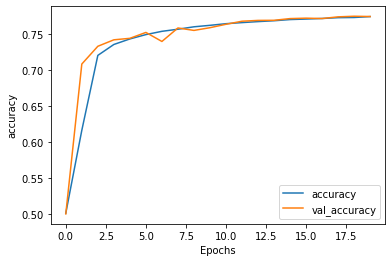

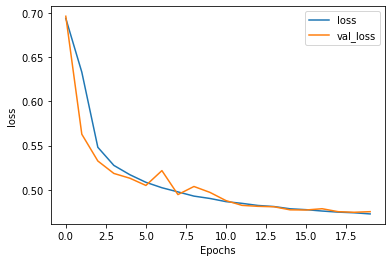

In [35]:
plot_graphs(history_simpleRNN, "accuracy")
plot_graphs(history_simpleRNN, "loss")

Motramos los principales resultados del modelo en términos de precisión, así como la matriz de confusión

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Train accuracy :0.7740004062652588
Val accuracy :0.7741031050682068


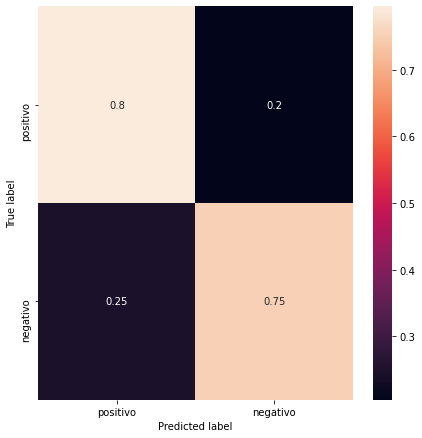

In [36]:
y_pred_simpleRNN = simpleRNN.predict_classes(x_val_pad) #np.argmax(model.predict(x), axis=-1)

history_dict_simpleRNN = history_simpleRNN.history
print(history_dict_simpleRNN.keys())

acc_simpleRNN = history_dict_simpleRNN['accuracy']
val_acc_simpleRNN = history_dict_simpleRNN['val_accuracy']
loss_simpleRNN = history_dict_simpleRNN['loss']
val_loss_simpleRNN = history_dict_simpleRNN['val_loss']

print('Train accuracy :' + str(acc_simpleRNN[-1]))
print('Val accuracy :' + str(val_acc_simpleRNN[-1]))

plot_confussion_matrix(labels = y_val_seq, predictions = y_pred_simpleRNN, classes = label_index.keys(), figsize = 6)

#### Bidirectional LSTM Architecture<a name="1nn"></a> 
[Volver al índice](#indice)

Tal y como hemos visto en clase, en esta sección aplicamos un Bidirectional LSTM. Se trata basicamente de una red neuronal recurrente que se emplea cuando tenemos un problema secuencial, como por ejemplo, una secuencia de texto. Los modelos LSTMs en concreto son ampliamente utilizados para estos problemas porque tratan de aprender como y cuando olvidar y cuando no, usando las diferentes neuronas de su arquitectura. Además, utilizando un LSTM bidireccional alimentamos el algoritmo con los datos originales de principio a fin y viceversa. Asimismo, al ser bidireccional aprende más rapido que si solo se usa una red neuronal en una única dirección.

In [28]:
def make_BILSTM(  bidirectional_layers = 1
               , bidirectional_dropout = 0.0
               , dense_layers = 1
               , dense_dropout = 0.0
               , lr = 1e-3
               , output_bias = None
               , verbose = 1):
    
    model = Sequential()
    
    model.add(Embedding(input_dim = len_word_index + 1 # the entering token j (j its a number) 
        #finds it´s word representation in the j row, where rows are "len_word_index + 1".
                       , output_dim = embedding_dim # word representation dimension
                       , weights = [embedding_matrix] # pretrained embedding
                       , input_length = max_length # Expected text size
                       , trainable = False)) # Trainable = True when embedding from scratch
    
    for i in range(0,bidirectional_layers):
        
        # return_sequences -> last bidirectional doesnt return requences
        return_sequences = ((bidirectional_layers - i) != 1)
        model.add(Bidirectional(LSTM(embedding_dim
                                 , activation = 'relu'
                                 , dropout = bidirectional_dropout # regularization 
                                 , recurrent_dropout = bidirectional_dropout # regularization
                                 , return_sequences = return_sequences))
                  )

    for i in range(0,dense_layers):
        model.add(Dense(embedding_dim, activation='relu')) # dense layers
        if dense_dropout != 0.0:
            model.add(Dropout(dense_dropout)) # regularization
            
    # bias the cost function
    if output_bias is not None:
        output_bias = initializers.Constant(output_bias)
    else:
        output_bias = 'zeros'    
    
    model.add(Dense(label_distinct 
                    , activation='softmax'
                    , bias_initializer = output_bias))    

    model.compile(loss = 'sparse_categorical_crossentropy' # return prob dist
                  , optimizer = Adam(lr) # classic classification optimizer
                  , metrics = ['accuracy'])
    if verbose:
        
        print('bidirectional_layers :' + str(bidirectional_layers))
        print('bidirectional_dropout :' + str(bidirectional_dropout))
        print('dense_layers :' + str(dense_layers))
        print('dense_dropout :' + str(dense_dropout))
        print('lr :' + str(lr))

        print(model.summary())
    
    return model

Una vez definidas las funciones generamos la red neuronal y graficamos para ir viendo los resultados de los datos de entrenamiento y validación

In [29]:
BILSTMmodel = make_BILSTM()

history_BILSTMmodel = BILSTMmodel.fit(x_train_pad, y_train_seq
                    , epochs=epochs
                    , batch_size = batch_size
                    , validation_data=(x_val_pad, y_val_seq)
                    , verbose=1)

bidirectional_layers :1
bidirectional_dropout :0.0
dense_layers :1
dense_dropout :0.0
lr :0.001
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 50)            24331350  
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               40400     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
Total params: 24,376,902
Trainable params: 45,552
Non-trainable params: 24,331,350
_________________________________________________________________
None
Epoch 1/20
2443/2443 [==============================] - 455s 184ms/step - loss: 0.5354 - accuracy: 0.7235 - val_loss: 0.4630 - val_acc

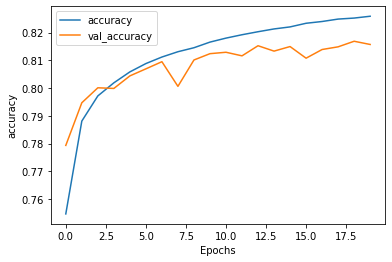

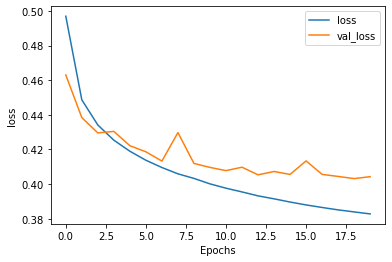

In [30]:
plot_graphs(history_BILSTMmodel, "accuracy")
plot_graphs(history_BILSTMmodel, "loss")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Train accuracy :0.8258872032165527
Val accuracy :0.8157187700271606


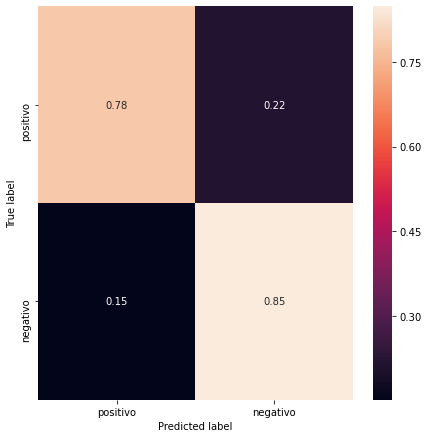

In [31]:
# predict over validation to assess model
y_pred = BILSTMmodel.predict_classes(x_val_pad) #np.argmax(model.predict(x), axis=-1)

history_dict = history_BILSTMmodel.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

print('Train accuracy :' + str(acc[-1]))
print('Val accuracy :' + str(val_acc[-1]))

plot_confussion_matrix(labels = y_val_seq, predictions = y_pred, classes = label_index.keys(), figsize = 6)

### Hyperparameter tuning <a name="2nn"></a> 
[Volver al índice](#indice)

A continuación realizamos un ajuste de parametros para ver cuales son los que nos permiten obtener la mayor precisión posible en la clasificación de texto. En concreto, se ha determinado diferentes parámetros en las capas bidireccionales, el dropout bidireaccional, las capas de la red y el dropout de la red. Teniendo en cuenta el elevado tiempo de computación que requiere algunos de los modelos propuestos, se puede también extender el número de modelos propuestos

Proposed 16 models
bidirectional_layers :1
bidirectional_dropout :0
dense_layers :1
dense_dropout :0.0
lr :0.001
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 40, 50)            24331350  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100)               40400     
_________________________________________________________________
dense_13 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 102       
Total params: 24,376,902
Trainable params: 45,552
Non-trainable params: 24,331,350
_________________________________________________________________
None
Epoch 1/20
2443/2443 [==============================] - 651s 265ms/step - loss: 0.5395 - accuracy: 0.7197 - val_loss:

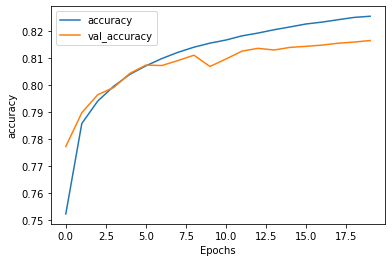

bidirectional_layers :1
bidirectional_dropout :0
dense_layers :1
dense_dropout :0.2
lr :0.001
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 40, 50)            24331350  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 100)               40400     
_________________________________________________________________
dense_15 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 102       
Total params: 24,376,902
Trainable params: 45,552
Non-trainable params: 24,331,350
_________________________________________________________________
None
Epoc

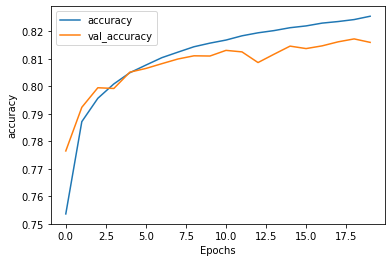

bidirectional_layers :1
bidirectional_dropout :0
dense_layers :2
dense_dropout :0.0
lr :0.001
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 40, 50)            24331350  
_________________________________________________________________
bidirectional_7 (Bidirection (None, 100)               40400     
_________________________________________________________________
dense_17 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_18 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 102       
Total params: 24,379,452
Trainable params: 48,102
Non-trainable params: 24,331,350
_________________________________________________________________
None
Epoc

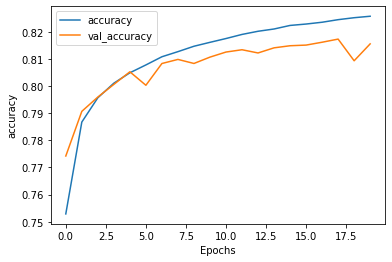

bidirectional_layers :1
bidirectional_dropout :0
dense_layers :2
dense_dropout :0.2
lr :0.001
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 40, 50)            24331350  
_________________________________________________________________
bidirectional_8 (Bidirection (None, 100)               40400     
_________________________________________________________________
dense_20 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________

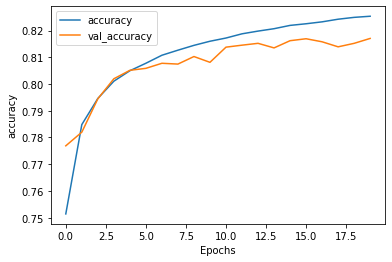

bidirectional_layers :1
bidirectional_dropout :0.1
dense_layers :1
dense_dropout :0.0
lr :0.001
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 40, 50)            24331350  
_________________________________________________________________
bidirectional_9 (Bidirection (None, 100)               40400     
_________________________________________________________________
dense_23 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 102       
Total params: 24,376,902
Trainable params: 45,552
Non-trainable params: 24,331,350
_________________________________________________________________
None
Epoch 1/20
2443/2443 [==============================] - 1478s 602ms/step - loss: 0.5550 - accuracy: 0.7087 - val_loss: 0.4713 - val_a

In [ ]:
bidirectional_layers = [1, 2]
bidirectional_dropout = [0, 0.1]
dense_layers = [1, 2]
dense_dropout = [0.0, 0.2]
epochs = 20

# Realiamos un diccionario donde incluimos las listas con los diferentes parámetros del modelo 
import itertools

param_grid = dict(bidirectional_layers = bidirectional_layers
               , bidirectional_dropout = bidirectional_dropout
               , dense_layers = dense_layers
               , dense_dropout = dense_dropout)

keys = param_grid.keys()
values = (param_grid[key] for key in keys)
param_grid = [dict(zip(keys, param_grid)) for param_grid in itertools.product(*values)]

print('Proposed ' + str(len(param_grid)) + ' models')

for j in range(0, len(param_grid)):
    
    bidirectional_layers = param_grid[j].get("bidirectional_layers")
    bidirectional_dropout = param_grid[j].get("bidirectional_dropout")
    dense_layers = param_grid[j].get("dense_layers")
    dense_dropout = param_grid[j].get("dense_dropout")
    
    model = make_BILSTM(bidirectional_layers = bidirectional_layers
                   , bidirectional_dropout = bidirectional_dropout
                   , dense_layers = dense_layers
                   , dense_dropout = dense_dropout
                   , verbose = 1)
    
    history = model.fit(x_train_pad, y_train_seq
                    , epochs=epochs
                    , batch_size = batch_size
                    , validation_data=(x_val_pad, y_val_seq)
                    , verbose=1)
    
    plot_graphs(history, 'accuracy')
    accuracy = pd.DataFrame.from_dict(history.history)['accuracy'].iloc[-1]
    param_grid[j].update( {'accuracy':accuracy})
    
results = pd.DataFrame(param_grid)

In [ ]:
results.sort_values(['accuracy'],ascending = False)

Nota: El código se ha tenido que parar debido a que excedía los limites de uso de Google Colab (con GPU). No obstante, tal y como pueden verse en los primeros modelos ejecutados, la precisión en los datos de entrenamiento y test no varía de forma significativa, con una precisión máxima de en torno al 83%.

### Conclusion<a name="2nn"></a> 
[Volver al índice](#indice)

Los resultados del modelo muestran una precisión del 83% a la hora de identificar cuando un tweet tiene un tono positivo o negativo. El modelo Bidireaccional LSTM permite mejorar los resultados obtenidos por la red neuronal recurrente (RNN) con una arquitectura básica. De cara a seguir mejorando los resultados, se podían seguir otras estrategias, como la utilización de un  Named entity recognition (NER) para la clasificación de texto. 